<a href="https://colab.research.google.com/github/mollah2022/Neural-Network/blob/main/MachineLearning25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ===============================================
# ✅ XGBoost for Genetic Disorder Prediction (Final Stable Version)
# ===============================================

!pip install -U xgboost==2.1.2 scikit-learn==1.5.2 imbalanced-learn==0.12.3 category_encoders==2.6.4 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Paths ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"
TEST_PATH  = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/test.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = [
    "Patient Id", "Patient First Name", "Family Name", "Father's name",
    "Institute Name", "Location of Institute"
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns (SAFE VERSION) ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build XGBoost Model ===
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_res)),
    learning_rate=0.05,
    n_estimators=500,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# === Train Model ===
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


✅ After SMOTE: (40808, 38) Class counts: [10202 10202 10202 10202]
[0]	validation_0-mlogloss:1.32684
[50]	validation_0-mlogloss:0.50964
[100]	validation_0-mlogloss:0.40000
[150]	validation_0-mlogloss:0.36422
[200]	validation_0-mlogloss:0.34481
[250]	validation_0-mlogloss:0.33096
[300]	validation_0-mlogloss:0.31963
[350]	validation_0-mlogloss:0.31107
[400]	validation_0-mlogloss:0.30294
[450]	validation_0-mlogloss:0.29707
[499]	validation_0-mlogloss:0.29242

✅ Validation Accuracy: 0.9051703013967165

Classification Report (Validation):
                                               precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.83      1.00      0.91      2043
Multifactorial genetic inheritance disorders       0.96      0.97      0.97      2072
            Single-gene inheritance diseases       0.91      0.89      0.90      2047
                                         nan       0.94      0.75      0.83      2000

                           

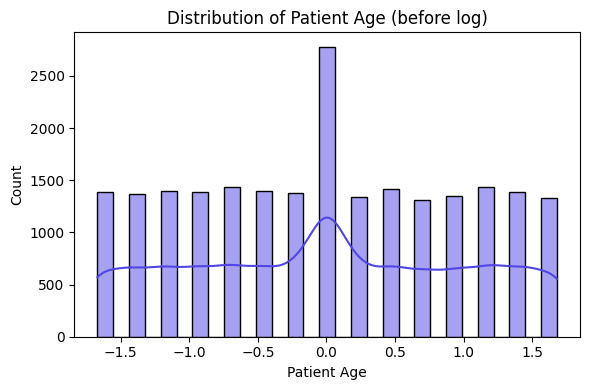

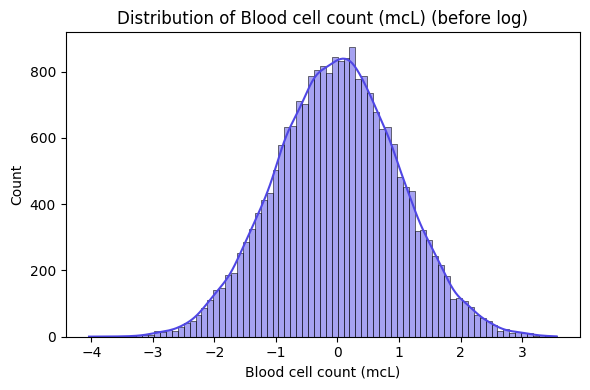

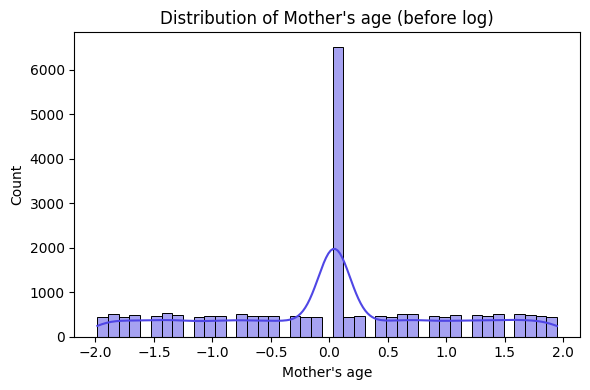

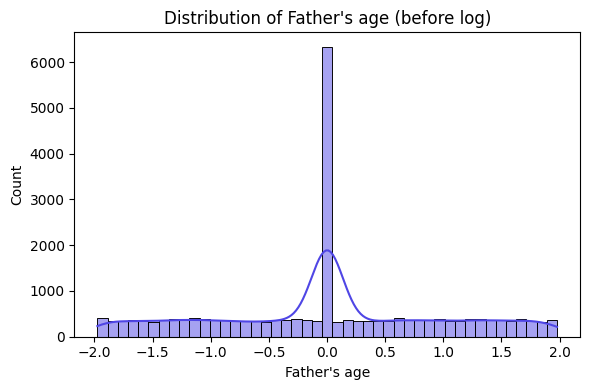

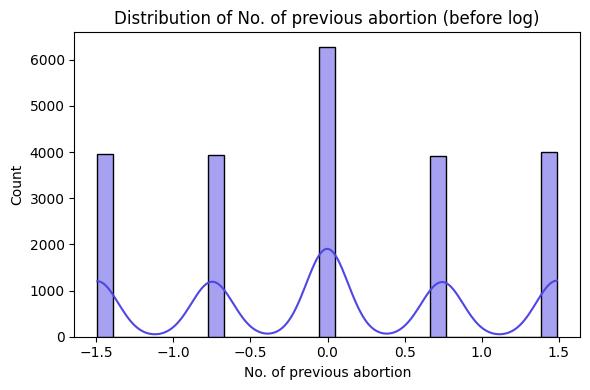

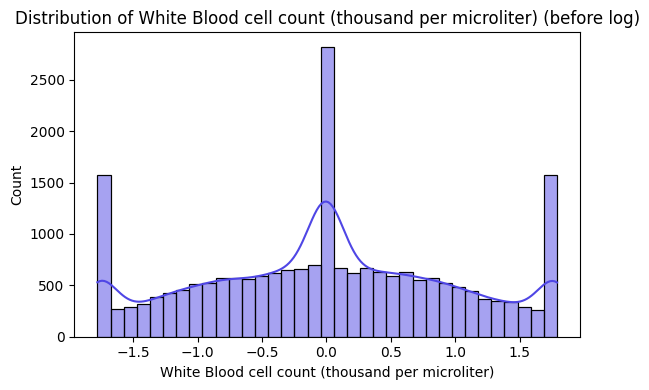

In [34]:
# ----- 4.2.1 -> distribution before log transform (for each numeric) -----
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(X[c], kde=True, color="#4f46e5")
    plt.title(f"Distribution of {c} (before log)")
    plt.tight_layout()
    plt.show()

# Create log-transformed copies (safe for non-positive -> shift)
X_log = X.copy()
for c in num_cols:
    shift = 1 - X[c].min() if X[c].min() <= 0 else 0
    X_log[c] = np.log1p(X[c] + shift)

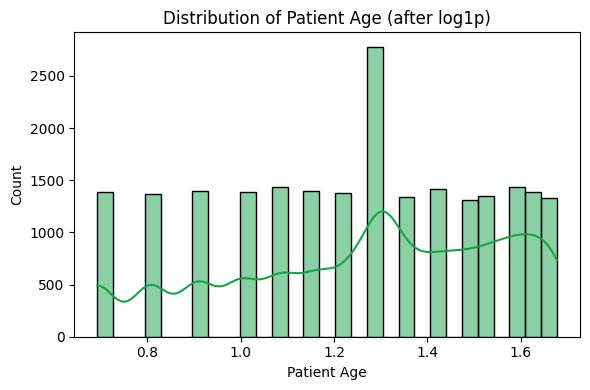

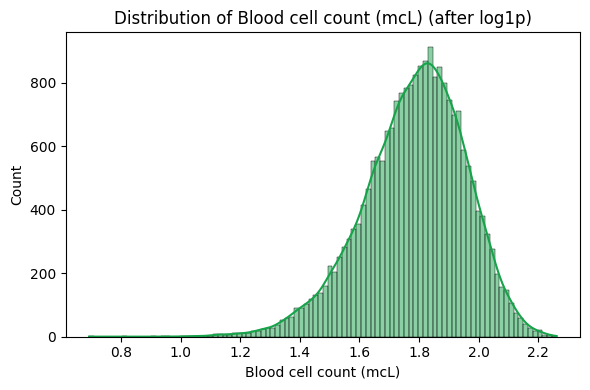

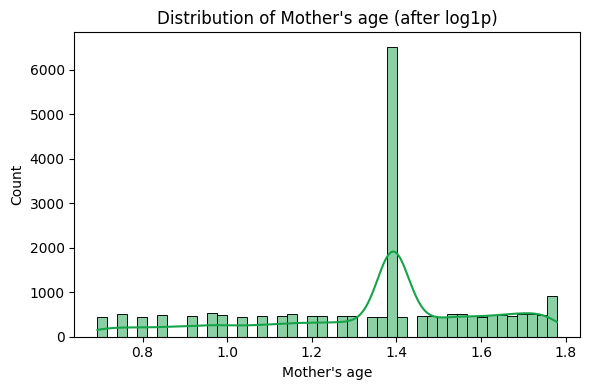

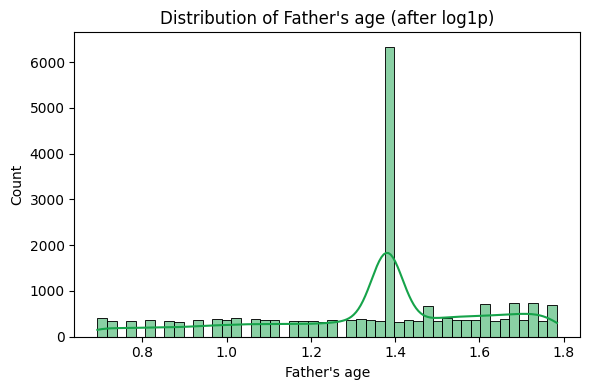

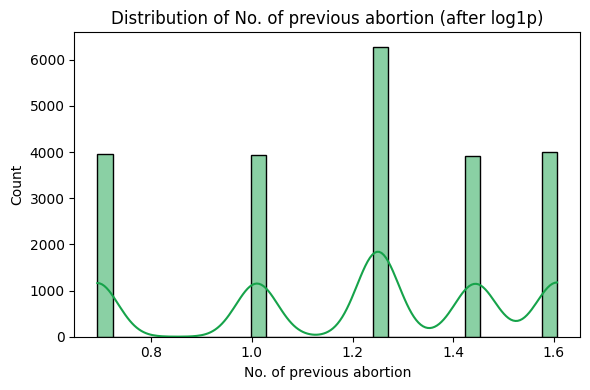

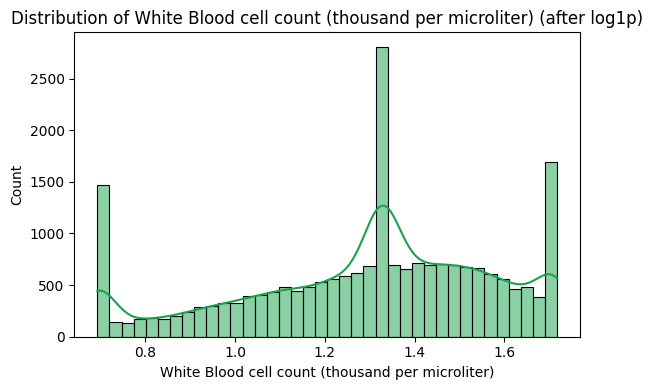

In [15]:
# ----- 4.2.1 -> distribution after log transform -----
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(X_log[c], kde=True, color="#16a34a")
    plt.title(f"Distribution of {c} (after log1p)")
    plt.tight_layout()
    plt.show()

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

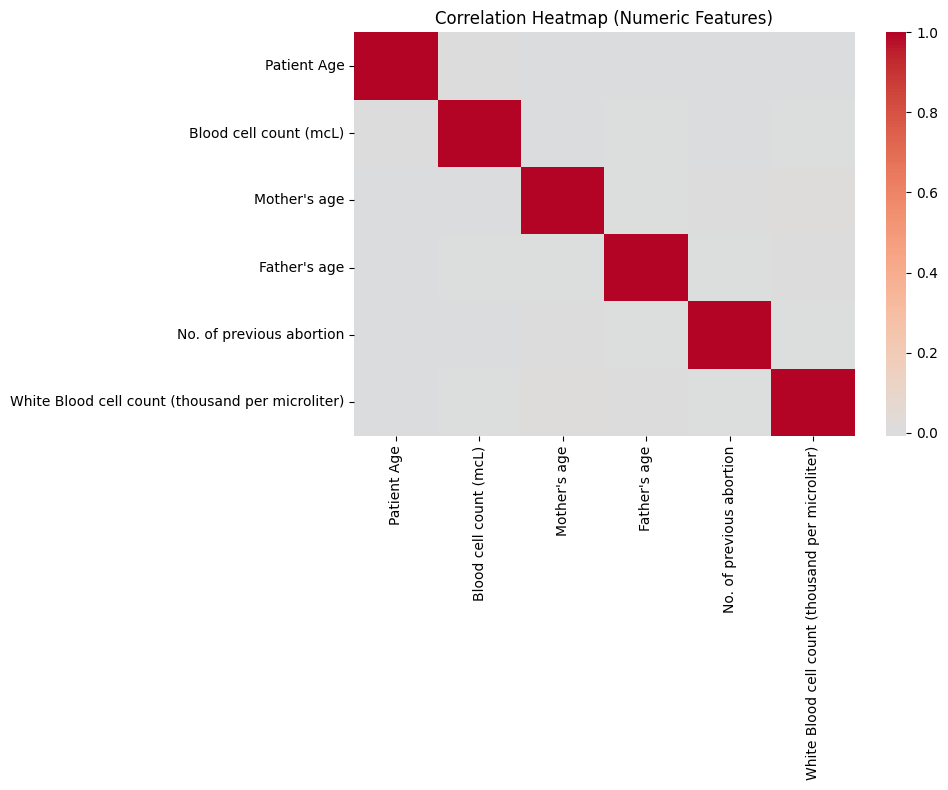

In [16]:
# ----- 4.2.2 -> correlation heatmap of features (numeric only) -----
plt.figure(figsize=(10,8))
corr = pd.DataFrame(X[num_cols], columns=num_cols).corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

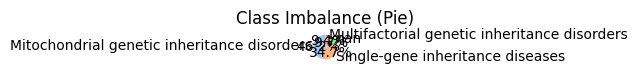

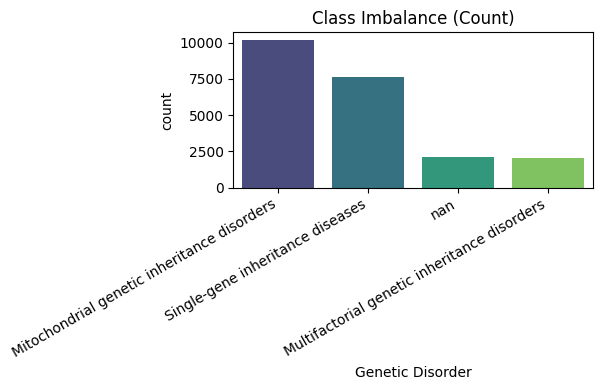

In [17]:
# ----- 4.2.3 -> class imbalance visualization (pie + count) -----
plt.figure(figsize=(5,5))
y.value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel"))
plt.ylabel("")
plt.title("Class Imbalance (Pie)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=y, order=y.value_counts().index, palette="viridis")
plt.title("Class Imbalance (Count)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

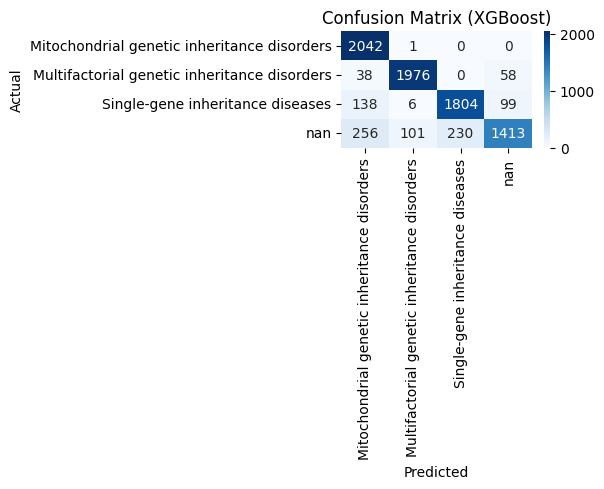

In [21]:
# ----- 4.5.1 -> confusion matrix of ANN model (here XGBoost) -----
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()

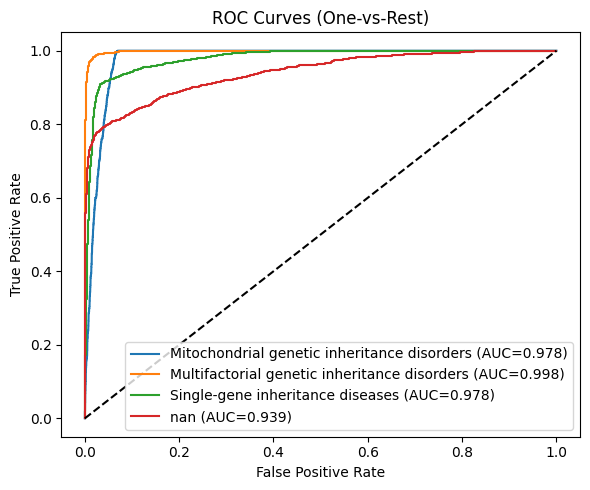

Macro-average AUC: 0.973264020793095


In [24]:
# ----- 4.5.2 -> ROC curve (one-vs-rest) -----
from sklearn.metrics import roc_curve, auc  # ✅ Add this import
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming model_proba is already fitted and proba is predicted
# Y_val_bin = label_binarize(y_val, classes=np.arange(len(le.classes_)))

plt.figure(figsize=(6,5))
macro_auc_list = []

for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(Y_val_bin[:, i], proba[:, i])
    roc_auc = auc(fpr, tpr)
    macro_auc_list.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.tight_layout()
plt.show()

print("Macro-average AUC:", np.mean(macro_auc_list))


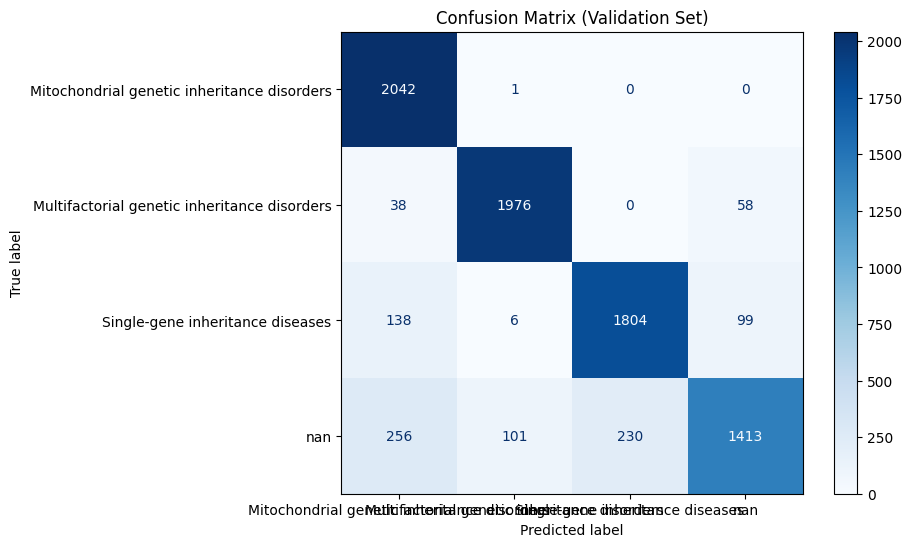

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_val, val_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [31]:
# ----- Table 4.1 -> model performance comparison (XGBoost vs simple baseline) -----
from sklearn.dummy import DummyClassifier
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_val)
base_acc = accuracy_score(y_val, base_pred)

xgb_acc = accuracy_score(y_val, val_preds)
perf_df = pd.DataFrame({
    "Model": ["Baseline (Most Frequent)", "XGBoost"],
    "Accuracy": [base_acc, xgb_acc]
})
display(perf_df)

,Model,Accuracy
0,Baseline (Most Frequent),0.245038
1,XGBoost,0.886425


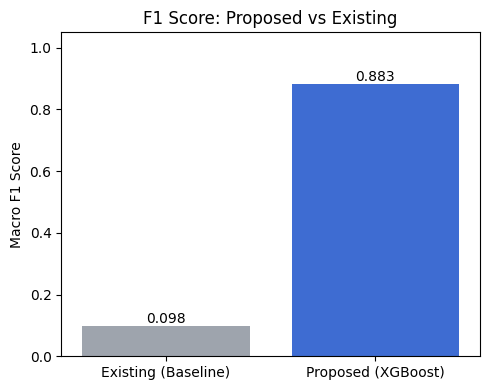

In [32]:
# ----- 4.7.1 -> bar chart comparing F1 Score of proposed vs existing -----
from sklearn.metrics import f1_score
base_f1 = f1_score(y_val, base_pred, average="macro")
xgb_f1 = f1_score(y_val, val_preds, average="macro")

plt.figure(figsize=(5,4))
sns.barplot(x=["Existing (Baseline)", "Proposed (XGBoost)"], y=[base_f1, xgb_f1], palette=["#9ca3af","#2563eb"])
plt.ylabel("Macro F1 Score")
plt.title("F1 Score: Proposed vs Existing")
for i, v in enumerate([base_f1, xgb_f1]):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [7]:
# ===============================================
# ✅ Random Forest for Genetic Disorder Prediction
# ===============================================

!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Path ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name",
             "Institute Name", "Location of Institute"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build Random Forest Model ===
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

# === Train Model ===
model.fit(X_train, y_train)

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.9.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.5.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cuml-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
cudf-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible

In [8]:
# ===============================================
# ✅ Logistic Regression for Genetic Disorder Prediction
# ===============================================

!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Path ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name",
             "Institute Name", "Location of Institute"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build Logistic Regression Model ===
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


✅ After SMOTE: (40808, 38) Class counts: [10202 10202 10202 10202]

✅ Validation Accuracy: 0.4625091889242833

Classification Report (Validation):
                                               precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.40      0.56      0.47      2043
Multifactorial genetic inheritance disorders       0.58      0.80      0.67      2072
            Single-gene inheritance diseases       0.43      0.26      0.33      2047
                                         nan       0.37      0.21      0.27      2000

                                    accuracy                           0.46      8162
                                   macro avg       0.44      0.46      0.43      8162
                                weighted avg       0.44      0.46      0.44      8162



In [9]:
# ===============================================
# ✅ Support Vector Machine (SVM) for Genetic Disorder Prediction
# ===============================================

!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Path ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name",
             "Institute Name", "Location of Institute"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build SVM Model ===
model = SVC(kernel='rbf', C=2, gamma='scale', probability=True, random_state=42)
model.fit(X_train, y_train)

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


✅ After SMOTE: (40808, 38) Class counts: [10202 10202 10202 10202]

✅ Validation Accuracy: 0.8020093114432737

Classification Report (Validation):
                                               precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.74      0.90      0.81      2043
Multifactorial genetic inheritance disorders       0.88      0.92      0.90      2072
            Single-gene inheritance diseases       0.81      0.87      0.84      2047
                                         nan       0.78      0.51      0.62      2000

                                    accuracy                           0.80      8162
                                   macro avg       0.80      0.80      0.79      8162
                                weighted avg       0.80      0.80      0.79      8162



In [10]:
# ===============================================
# ✅ Gradient Boosting for Genetic Disorder Prediction
# ===============================================

!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Path ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name",
             "Institute Name", "Location of Institute"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build Gradient Boosting Model ===
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


✅ After SMOTE: (40808, 38) Class counts: [10202 10202 10202 10202]

✅ Validation Accuracy: 0.889487870619946

Classification Report (Validation):
                                               precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.83      1.00      0.90      2043
Multifactorial genetic inheritance disorders       0.95      0.96      0.95      2072
            Single-gene inheritance diseases       0.89      0.89      0.89      2047
                                         nan       0.91      0.71      0.80      2000

                                    accuracy                           0.89      8162
                                   macro avg       0.89      0.89      0.89      8162
                                weighted avg       0.89      0.89      0.89      8162



In [11]:
# ===============================================
# ✅ AdaBoost for Genetic Disorder Prediction
# ===============================================

!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Path ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name",
             "Institute Name", "Location of Institute"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build AdaBoost Model ===
model = AdaBoostClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train)

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


✅ After SMOTE: (40808, 38) Class counts: [10202 10202 10202 10202]

✅ Validation Accuracy: 0.48934084783141385

Classification Report (Validation):
                                               precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.74      0.99      0.85      2043
Multifactorial genetic inheritance disorders       0.82      0.25      0.38      2072
            Single-gene inheritance diseases       0.52      0.01      0.02      2047
                                         nan       0.30      0.71      0.42      2000

                                    accuracy                           0.49      8162
                                   macro avg       0.60      0.49      0.42      8162
                                weighted avg       0.60      0.49      0.42      8162



In [12]:
# ===============================================
# ✅ CatBoost for Genetic Disorder Prediction
# ===============================================

!pip install -U catboost==1.2.6 scikit-learn==1.5.2 imbalanced-learn==0.12.3 numpy==1.26.4 pandas -q

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# === File Path ===
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/datasetDisorder/train.csv"

# === Load Dataset ===
df = pd.read_csv(TRAIN_PATH)
TARGET = "Genetic Disorder"
y = df[TARGET].astype(str)

# === Drop unnecessary columns ===
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name",
             "Institute Name", "Location of Institute"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

X = df.drop(columns=[TARGET])

# === Identify numeric & categorical columns ===
num_cols = [c for c in X.columns if X[c].dtype != 'object' and X[c].nunique() > 2]
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() <= 20]

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# === Encode categorical columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# === Scale numeric columns ===
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === Encode target labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Balance dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_enc)
print("✅ After SMOTE:", X_res.shape, "Class counts:", np.bincount(y_res))

# === Split Train/Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# === Build CatBoost Model ===
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='MultiClass',
    random_seed=42,
    verbose=50
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# === Evaluate on Validation Set ===
val_preds = model.predict(X_val)
print("\n✅ Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report (Validation):\n", classification_report(y_val, val_preds, target_names=le.classes_))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00
✅ After SMOTE: (40808, 38) Class counts: [10202 10202 10202 10202]
0:	learn: 1.3192645	test: 1.3183654	best: 1.3183654 (0)	total: 112ms	remaining: 56s
50:	learn: 0.5808864	test: 0.5718841	best: 0.5718841 (50)	total: 2.74s	remaining: 24.1s
100:	learn: 0.4772122	test: 0.4715652	best: 0.4715652 (100)	total: 5.43s	remaining: 21.5s
150:	learn: 0.4383432	test: 0.4378315	best: 0.4378315 (150)	total: 8.19s	remaining: 18.9s
200:	learn: 0.4136534	test: 0.4179121	best: 0.4179121 (200)	total: 12.6s	remaining: 18.8s
250:	learn: 0.3940573	test: 0.4028440	best: 0.4028440 (250)	total: 15.3s	remaining: 15.1s
300:	learn: 0.3784083	test: 0.3922530	best: 0.3922530 (300)	total: 17.9s	remaining: 11.8s
350:	learn: 0.3644889	test: 0.3837464	best: 0.3837464 (350)	total: 20.5s	remaining: 8.72s
400:	learn: 0.3514477	test: 0.3764223	best: 0.3764223 (400)	total: 24.3s	remaining: 6s
450:	learn: 0.3402289	test: 0.3703579	best: 0.3703579 (4